## defines

In [28]:
import pandas as pd
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

In [3]:
def get_vars_df(sheet_id, gid):
  return pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}')

## load and clean data

In [4]:
# read data
data = pd.read_csv("mimic_iv+_sepsis_first24h.csv")
# limit to one encounter per subject
data = data.sort_values(by='anchor_year_group').groupby('subject_id').first()
# process
data = data.rename(columns={'hospital_expire_flag': 'in_hospital_mortality',})
data['BMI_admission'] = data['weight_admit'] / ((data['height']/100)**2)

data['los_7d'] = data['los'].apply(lambda x: 1 if x >= 7 else 0)

# Map the 'race' column in the 'mimic_iv_pat' DataFrame
sheets_id = "1Hv_sOd0--6TPYiB3Crjdn_JrIhIazXXJc05mL4GefOU"
gid = "1877090341"
mimic_iv_map = get_vars_df(sheets_id, gid)
mapping_series = mimic_iv_map.set_index('original')['mapping']
data['race'] = data['race'].map(mapping_series)

data['language'] = data['language'].apply(
    lambda x: "Proficient" if x == "ENGLISH" else "Non-Proficient"
)

data['insurance'] = data['insurance'].apply(
    lambda x: x if x == "Other" else "Medicare/Medicaid"
)

# create dummies for categorical variables
cat_cols = ['race','language','insurance','ventilation_firstday']

for c in cat_cols:
    data = data.join(pd.get_dummies(data[c], prefix=c))


data = data.drop(columns=['first_careunit','ventilation_firstday'])

# drop columns that cannot be used for prediction
data = data.drop(columns=[
    'hadm_id',
    'stay_id',
    'intime',
    'outtime',
    'los',
    'last_careunit',
    'row_number',
    'hadm_id',
    'stay_id',
    'admittime',
    'dischtime',
    'ICU_duration',
    'height',
    'weight_max',
    'weight_min',
    'weight_admit',
    'y17_19',
    'y08_y16',
    'y20_y22',
    'y08_y19'
])

data = data.rename(columns={'race':'Race',
                            'language':'English Proficiency',
                            'insurance': 'Insurance'
                           })

In [5]:
with pd.option_context('display.max_columns', None):
    display(data.head())

,anchor_year_group,age,Race,English Proficiency,Insurance,ED_duration,preICU_time_adm,preICU_time_ED,in_hospital_mortality,resp_max,coagulation_max,liver_max,cardio_max,cns_max,renal_max,sofa_d1_max,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_sd,sbp_min,sbp_max,sbp_mean,sbp_sd,dbp_min,dbp_max,dbp_mean,dbp_sd,mbp_min,mbp_max,mbp_mean,mbp_sd,resp_rate_min,resp_rate_max,resp_rate_mean,resp_rate_sd,temperature_min,temperature_max,temperature_mean,temperature_sd,spo2_min,spo2_max,spo2_mean,spo2_sd,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,sodium_min,sodium_max,potassium_min,potassium_max,abs_basophils_min,abs_basophils_max,abs_eosinophils_min,abs_eosinophils_max,abs_lymphocytes_min,abs_lymphocytes_max,abs_monocytes_min,abs_monocytes_max,abs_neutrophils_min,abs_neutrophils_max,atyps_min,atyps_max,bands_min,bands_max,imm_granulocytes_min,imm_granulocytes_max,metas_min,metas_max,nrbc_min,nrbc_max,d_dimer_min,d_dimer_max,fibrinogen_min,fibrinogen_max,thrombin_min,thrombin_max,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max,alt_min,alt_max,alp_min,alp_max,ast_min,ast_max,amylase_min,amylase_max,bilirubin_total_min,bilirubin_total_max,bilirubin_direct_min,bilirubin_direct_max,bilirubin_indirect_min,bilirubin_indirect_max,ck_cpk_min,ck_cpk_max,ck_mb_min,ck_mb_max,ggt_min,ggt_max,ld_ldh_min,ld_ldh_max,dialysis_active,urineoutput,pressor_firstday,charlson_comorbidity_index,BMI_admission,los_7d,race_American Indian / Alaska Native,race_Asian,race_Black,race_Hispanic OR Latino,race_More Than One Race,race_Native Hawaiian / Pacific Islander,race_Unknown,race_White,language_Non-Proficient,language_Proficient,insurance_Medicare/Medicaid,insurance_Other,ventilation_firstday_HF,ventilation_firstday_INV,ventilation_firstday_Non-INV,ventilation_firstday_Other
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001843,2017 - 2019,73,White,Proficient,Other,NaN,18,NaN,1,0,0,2,1,1,1,5,90.0,155.0,123.294118,15.015678,72.0,114.0,91.294118,14.990683,27.0,85.0,60.941176,15.513988,34.0,90.0,67.470588,14.790697,16.0,27.0,21.176471,3.587919,36.39,36.61,36.480000,0.115326,84.0,99.0,95.117647,3.871084,31.6,32.4,9.1,9.5,551.0,609.0,10.5,13.8,NaN,NaN,NaN,NaN,NaN,NaN,11.0,16.0,20.0,29.0,27.0,33.0,8.2,9.3,97.0,101.0,1.3,1.7,137.0,138.0,3.9,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.1,2.1,23.4,23.5,42.0,75.9,78.0,90.0,545.0,564.0,140.0,196.0,NaN,NaN,4.2,4.5,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN,NaN,924.0,949.0,NaN,215.0,0,15,NaN,0,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,True
10001884,2008 - 2010,68,Black,Proficient,Medicare/Medicaid,9.0,80,78.0,1,0,1,0,3,0,0,4,38.0,80.0,71.392857,7.631995,93.0,180.0,123.730769,22.851797,12.0,123.0,72.884615,18.411577,46.0,130.0,86.038462,15.172293,10.0,26.0,17.775862,3.054815,35.10,37.20,36.573684,0.577198,89.0,100.0,98.259259,3.492768,33.6,36.0,10.4,11.4,149.0,171.0,12.0,18.4,3.5,3.5,NaN,NaN,NaN,NaN,11.0,11.0,33.0,33.0,26.0,30.0,8.7,9.8,96.0,98.0,1.0,1.1,136.0,138.0,4.0,4.2,0.0000,0.0000,0.0000,0.0000,0.5500,0.5500,0.7400,0.7400,17.110,17.110,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,1.4,13.5,15.3,21.3,150.0,116.0,167.0,48.0,55.0,55.0,134.0,NaN,NaN,0.2,0.4,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,NaN,NaN,NaN,1560.0,1,5,26.370238,1,False,False,True,False,False,False,False,False,False,True,True,False,False,True,False,False
10002013,2008 - 2010,53,Unknown,Proficient,Medicare/Medicaid,NaN,3,NaN,0,3,0,0,1,0,0,4,80.0,105.0,94.636364,5.447109,80.0,147.5,111.865385,17.109388,50.5,79.0,61.

## split validation sets

In [6]:
data.anchor_year_group.value_counts()

anchor_year_group
2008 - 2010    9390
2011 - 2013    6778
2014 - 2016    6373
2017 - 2019    4653
2020 - 2022    3177
Name: count, dtype: int64

In [7]:
data['set'] = data['anchor_year_group'].apply(
    lambda x: 'train' if x in ["2008 - 2010", "2011 - 2013", "2014 - 2016"] else(
        'val_pre_covid' if x == "2017 - 2019" else(
            'val_post_covid' if x == "2020 - 2022" else np.nan
        )
    )
)
data = data.drop(columns=['anchor_year_group'])


In [8]:
data['set'].value_counts(normalize=True)

set
train             0.742188
val_pre_covid     0.153205
val_post_covid    0.104606
Name: proportion, dtype: float64

In [9]:
data['set'].isna().sum()

0

## functions

### sample weigths

### compute metrics

In [10]:
def compute_metrics_long_format(y_true,
                                y_pred_proba,
                                seed,
                                target,
                                val_set,
                                sens_attributes,
                                c_test_sens
                               ):
    results = []
    
    for sens_attribute in sens_attributes:
        c_test = c_test_sens[sens_attribute]
    
        unique_classes = c_test.unique()
    
        metrics_list = [
            'AUROC',
            # 'AUPRC',
            'Accuracy',
            'Recall',
            # 'Precision',
            'F1-score',
            # 'Balanced Accuracy'
        ]
        
        functions_list = [
            roc_auc_score,
            # average_precision_score,
            accuracy_score,
            recall_score,
            # precision_score,
            f1_score,
            # balanced_accuracy_score
        ]
    
        for cls in unique_classes:
            idx = c_test == cls
            for metric, func in zip(metrics_list, functions_list):
                try:
                    value = func(y_true[idx], (y_pred_proba[idx] > 0.5).astype(int)) \
                                               if metric not in ['AUROC','AUPRC'] else func(y_true[idx], y_pred_proba[idx])
                except:
                    value = np.nan
                
                results.append({
                    'Task': target,
                    'Validation Set': val_set,
                    'Seed': seed,
                    'Attribute': sens_attribute,
                    'Class': cls,
                    'Metric': metric,
                    'Value': value
                })
    
        # Compute metrics for all classes combined    
        overall_metrics = {}
        for metric, func in zip(metrics_list, functions_list):
            overall_metrics[metric] = func(y_true, (y_pred_proba > 0.5).astype(float))\
                                           if metric not in ['AUROC','AUPRC'] else func(y_true, y_pred_proba)
    
        for metric, value in overall_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': '',
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })
    
        # compute fairness metrics as well
        fairness_metrics = {}
        
        fairness_metrics_list = [
            'Demographic Parity Ratio',
            'Equalized Odds Ratio'
        ]
        
        fairness_functions_list = [
            demographic_parity_ratio,
            equalized_odds_ratio
        ]
    
        for metric, func in zip(fairness_metrics_list, fairness_functions_list):
            fairness_metrics[metric] = func(y_true=y_true,
                                            y_pred=(y_pred_proba > 0.5).astype(int),
                                            sensitive_features=c_test)
    
        for metric, value in fairness_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': sens_attribute,
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })

    return pd.DataFrame(results)

In [11]:
def get_sample_weights(y_train):
    
    classes_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    
    sample_weights = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        sample_weights[i] = classes_weights[int(val)]

    return sample_weights

### train and test models

In [12]:
def train_model(data,
                features,
                target='in_hospital_mortality',
                model=XGBClassifier(),
               ):
    
    X_train = data.loc[data['set'] == 'train', features]
    y_train = data.loc[data['set'] == 'train', target]

    # Train, test, eval model with sample weights
    model.fit(X_train, y_train, sample_weight=get_sample_weights(y_train))
    
    return model


def test_model(data,
               features,
               metrics_all,
               model,
               target='in_hospital_mortality',
               val_set='val_pre_covid',
               sens_attributes=['race'],
               seed=42,
              ):


    X_test = data.loc[data['set'] == val_set, features]
    y_test = data.loc[data['set'] == val_set, target]
    
    np.random.seed(s)
    resample = np.random.randint(0, len(X_test), size=int(.8*len(X_test)))

    X_test = X_test.iloc[resample]
    y_test = y_test.iloc[resample]

    # classes of sensitive attributes in the test set
    c_test_sens = data.loc[data['set'] == val_set, sens_attributes].iloc[resample]

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics_fold = compute_metrics_long_format(y_test, y_pred_proba, seed,
                                               target, val_set, sens_attributes, 
                                               c_test_sens)

    metrics_all = pd.concat([metrics_all, metrics_fold], axis=0)

    return metrics_all.drop_duplicates()
    

### 95% confidence intervals

In [13]:
def mean_ci_agg(data):
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(len(data))
    ci_width = 1.96 * se
    lower_ci = mean - ci_width
    upper_ci = mean + ci_width
    return f"{mean:.3f} ({lower_ci:.3f} - {upper_ci:.3f})"

### p values

In [14]:
def compute_p_value(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]
    
    _, p_value = ttest_ind(*group_values)  

    if p_value < .001:
        return '<.001'
    elif p_value < .01:
        return '<.01'
    else:
        return np.round(p_value, 3)

### mean differences

In [15]:
def calculate_md(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]

    mean_diff = np.mean(group_values[1]) - np.mean(group_values[0])

    return mean_diff

### process metrics

In [16]:
def process_metrics(metrics_all):
    
    pivoted_metrics = metrics_all.pivot(
        index=['Seed', 'Metric', 'Attribute','Class'],
        columns=['Task','Validation Set'],
        values=['Value']
    ).groupby(['Metric', 'Attribute','Class',]) \
     .agg(mean_ci_agg) \
     .droplevel(0,axis=1)

    # return pivoted_metrics
    
    p_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
                          .apply(compute_p_value) \
                          .reset_index(name='p_value') \
                          .pivot(
                              columns='Task',
                              index=['Metric', 'Attribute', 'Class'],
                              values='p_value') \
                          .round(3)
    
    p_values.columns = pd.MultiIndex.from_product([p_values.columns, ['p_value']])
    p_values.columns.name = ('Task', 'Validation Set')
    
    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')

    md_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
        .apply(calculate_md) \
        .reset_index(name='mean_diff') \
        .pivot(
            columns='Task',
            index=['Metric', 'Attribute', 'Class'],
            values='mean_diff') \
        .round(3)

    md_values.columns = pd.MultiIndex.from_product([md_values.columns, ['mean_diff']])
    md_values.columns.name = ('Task', 'Validation Set')

    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values, md_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')
   
    pivoted_metrics_p = pivoted_metrics_p.sort_index(level=[0,1], axis=1, ascending=False)
    
    return pivoted_metrics_p

### feature importance

In [17]:
def get_explain_plot(fit_model, X): 
    explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(X)  
    shap.summary_plot(shap_values, X, plot_size=(8,6)) 

## main

### distributions

In [18]:
first_units = data.columns[
        data.columns.str.contains('first_careunit')
].tolist()

tableone(data,
         groupby='set',
         columns=['in_hospital_mortality','los_7d','Race','English Proficiency', 'Insurance',],
         order={'in_hospital_mortality':[1,0],'los_7d':[1,0]},
         limit={'in_hospital_mortality': 1,'los_7d': 1},
        )
         # columns=['Race','English Proficiency', 'Insurance'] + first_units)

Grouped by set                                                         
                                                                       Missing       Overall         train val_post_covid val_pre_covid
n                                                                                      30371         22541           3177          4653
in_hospital_mortality, n (%) 1                                               0   5274 (17.4)   3478 (15.4)     842 (26.5)    954 (20.5)
los_7d, n (%)                1                                               0   6755 (22.2)   4466 (19.8)    1029 (32.4)   1260 (27.1)
Race, n (%)                  American Indian / Alaska Native                 0      66 (0.2)      42 (0.2)        9 (0.3)      15 (0.3)
                             Asian                                                 885 (2.9)     660 (2.9)       92 (2.9)     133 (2.9)
                             Black                                                2780 (9.2)    2214 (9.8)      226 (7.1)     340 (7.3)
                             Hispanic OR Latino                                   1075 (3.5)     843 (3.7)      104 (3.3)     128 (2.8)
                             More Than One Race                                     28 (0.1)      28 (0.1)                             
                             Native Hawaiian / Pacific Islander                     52 (0.2)      33 (0.1)        4 (0.1)      15 (0.3)
                             Unknown                                             5397 (17.8)   3140 (13.9)    1049 (33.0)   1208 (26.0)
                             White                                              20088 (66.1)  15581 (69.1)    1693 (53.3)   2814 (60.5)
English Proficiency, n (%)   Non-Proficient                                  0   3217 (10.6)   2424 (10.8)      312 (9.8)    481 (10.3)
                             Proficient                                         27154 (89.4)  20117 (89.2)    2865 (90.2)   4172 (89.7)
Insurance, n (%)             Medicare/Medicaid                               0  16088 (53.0)  12429 (55.1)    1403 (44.2)   2256 (48.5)
                             Other                                              14283 (47.0)  10112 (44.9)    1774 (55.8)   2397 (51.5)

In [19]:
['Race','English Proficiency', 'Insurance', 'first_careunit'] + first_units

['Race', 'English Proficiency', 'Insurance', 'first_careunit']

### models

In [32]:

seeds = np.arange(0, 10, 1)
val_sets = ['val_pre_covid', 'val_post_covid']
targets = [
    'in_hospital_mortality',
    'los_7d',
    # 'odd_icustay_id' # outcome control
]
sens_attributes = [
    'Race',
    'English Proficiency',
    'Insurance'
    # 'sex_female' # sensitive attribute control
]

models = [
    LGBMClassifier(verbosity=-1),
    RandomForestClassifier(),
    XGBClassifier(),
]
models_names = ['LGBM','RF','XGB']#, 'LR']



for model, model_name in zip(models, models_names):
    print(model_name)

    metrics_all = pd.DataFrame()
    
    for t in targets:
        print(t)
        features = data.columns.drop(['in_hospital_mortality','los_7d','set'] + sens_attributes)
        fit_model = train_model(
            data,
            features,
            t,
            model,  
        )
        for vs in val_sets:
                for s in tqdm(seeds):
                    
                    metrics_all = test_model(
                        data,
                        features,
                        metrics_all=metrics_all,
                        model=fit_model,
                        target=t,
                        val_set=vs,
                        sens_attributes=sens_attributes,
                        seed=s,
                    )
        pivoted_metrics = process_metrics(metrics_all)
        pivoted_metrics.to_csv(f'results/covid_{model_name}.csv')


LGBM
in_hospital_mortality


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]


los_7d


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]


RF
in_hospital_mortality


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.72it/s]


los_7d


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]


XGB
in_hospital_mortality


100%|███████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


los_7d


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


### metrics

In [33]:
pivoted_metrics.iloc[(pivoted_metrics.index.get_level_values('Class') == 'Overall')]

Task                                                                 los_7d  \
                                                              val_pre_covid   
Metric                   Attribute           Class                            
AUROC                                        Overall  0.822 (0.819 - 0.825)   
Accuracy                                     Overall  0.778 (0.774 - 0.782)   
Demographic Parity Ratio English Proficiency Overall  0.924 (0.880 - 0.967)   
                         Insurance           Overall  0.881 (0.845 - 0.916)   
                         Race                Overall  0.372 (0.285 - 0.458)   
Equalized Odds Ratio     English Proficiency Overall  0.878 (0.840 - 0.917)   
                         Insurance           Overall  0.815 (0.774 - 0.855)   
                         Race                Overall  0.074 (0.002 - 0.145)   
F1-score                                     Overall  0.604 (0.598 - 0.610)   
Recall                                       Overall  0.624 (0.618 - 0.631)   

Task                                                                         \
                                                             val_post_covid   
Metric                   Attribute           Class                            
AUROC                                        Overall  0.768 (0.764 - 0.772)   
Accuracy                                     Overall  0.719 (0.713 - 0.725)   
Demographic Parity Ratio English Proficiency Overall  0.905 (0.869 - 0.942)   
                         Insurance           Overall  0.861 (0.832 - 0.891)   
                         Race                Overall  0.203 (0.090 - 0.315)   
Equalized Odds Ratio     English Proficiency Overall  0.804 (0.750 - 0.858)   
                         Insurance           Overall  0.840 (0.794 - 0.886)   
                         Race                Overall  0.000 (0.000 - 0.000)   
F1-score                                     Overall  0.558 (0.550 - 0.566)   
Recall                                       Overall  0.539 (0.529 - 0.549)   

Task                                                                    \
                                                     p_value mean_diff   
Metric                   Attribute           Class                       
AUROC                                        Overall   <.001    -0.054   
Accuracy                                     Overall   <.001    -0.059   
Demographic Parity Ratio English Proficiency Overall   0.552    -0.019   
                         Insurance           Overall   0.434    -0.020   
                         Race                Overall    0.04    -0.169   
Equalized Odds Ratio     English Proficiency Overall   0.054    -0.074   
                         Insurance           Overall    0.45     0.026   
                         Race                Overall   0.071    -0.074   
F1-score                                     Overall   <.001    -0.046   
Recall                                       Overall   <.001    -0.085   

Task                                                  in_hospital_mortality  \
                                                              val_pre_covid   
Metric                   Attribute           Class                            
AUROC                                        Overall  0.847 (0.842 - 0.852)   
Accuracy                                     Overall  0.808 (0.804 - 0.811)   
Demographic Parity Ratio English Proficiency Overall  0.904 (0.882 - 0.927)   
                         Insurance           Overall  0.845 (0.819 - 0.871)   
                         Race                Overall  0.317 (0.244 - 0.390)   
Equalized Odds Ratio     English Proficiency Overall  0.874 (0.836 - 0.912)   
                         Insurance           Overall  0.760 (0.722 - 0.799)   
                         Race                Overall  0.110 (0.019 - 0.201)   
F1-score                                     Overall  0.576 (0.567 - 0.585)   
Recall                           

In [34]:
pivoted_metrics

Task                                                                                            los_7d  \
                                                                                         val_pre_covid   
Metric                   Attribute           Class                                                       
AUROC                                        Overall                             0.822 (0.819 - 0.825)   
                         English Proficiency Non-Proficient                      0.831 (0.816 - 0.845)   
                                             Proficient                          0.821 (0.817 - 0.825)   
                         Insurance           Medicare/Medicaid                   0.827 (0.822 - 0.832)   
                                             Other                               0.817 (0.812 - 0.822)   
                         Race                American Indian / Alaska Native     0.906 (0.827 - 0.985)   
                                             Asian                               0.792 (0.762 - 0.821)   
                                             Black                               0.789 (0.771 - 0.807)   
                                             Hispanic OR Latino                  0.842 (0.830 - 0.854)   
                                             Native Hawaiian / Pacific Islander  0.750 (0.651 - 0.850)   
                                             Unknown                             0.812 (0.803 - 0.820)   
                                             White                               0.825 (0.819 - 0.832)   
Accuracy                                     Overall                             0.778 (0.774 - 0.782)   
                         English Proficiency Non-Proficient                      0.772 (0.761 - 0.784)   
                                             Proficient                          0.779 (0.775 - 0.782)   
                         Insurance           Medicare/Medicaid                   0.791 (0.786 - 0.796)   
                                             Other                               0.765 (0.760 - 0.771)   
                         Race                American Indian / Alaska Native     0.850 (0.755 - 0.944)   
                                             Asian                               0.797 (0.780 - 0.815)   
                                             Black                               0.780 (0.765 - 0.794)   
                                             Hispanic OR Latino                  0.790 (0.776 - 0.804)   
                                             Native Hawaiian / Pacific Islander  0.551 (0.474 - 0.627)   
                                             Unknown                             0.751 (0.743 - 0.760)   
                                             White                               0.788 (0.783 - 0.794)   
Demographic Parity Ratio English Proficiency Overall                             0.924 (0.880 - 0.967)   
                         Insurance           Overall                             0.881 (0.845 - 0.916)   
                         Race                Overall                             0.372 (0.285 - 0.458)   
Equalized Odds Ratio     English Proficiency Overall                             0.878 (0.840 - 0.917)   
                         Insurance           Overall                             0.815 (0.774 - 0.855)   
                         Race                Overall                             0.074 (0.002 - 0.145)   
F1-score                                     Overall                             0.604 (0.598 - 0.610)   
                         English Proficiency Non-Proficient                      0.640 (0.622 - 0.659)   
                                             Proficient                          0.599 (0.592 - 0.606)   
                         Insurance           Medicare/Medicaid                   0.606 (0.599 - 0.613)   
                                             Other                            

### feature importance

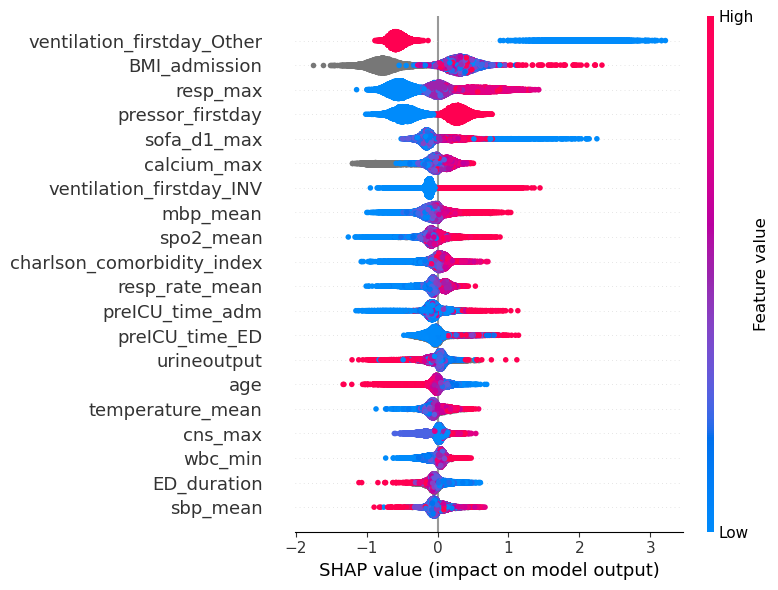

In [35]:
get_explain_plot(fit_model, data.loc[data['set'] == 'train', features])

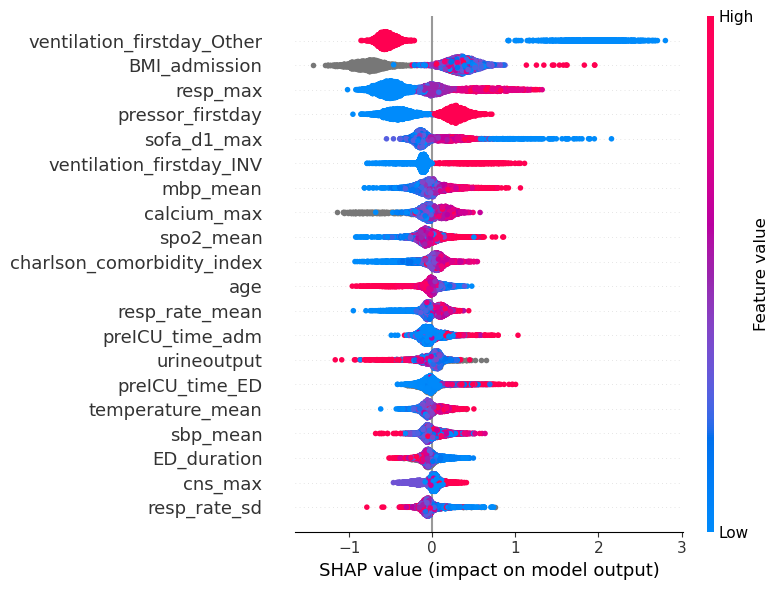

In [36]:
get_explain_plot(fit_model, data.loc[data['set'] == 'val_pre_covid', features])

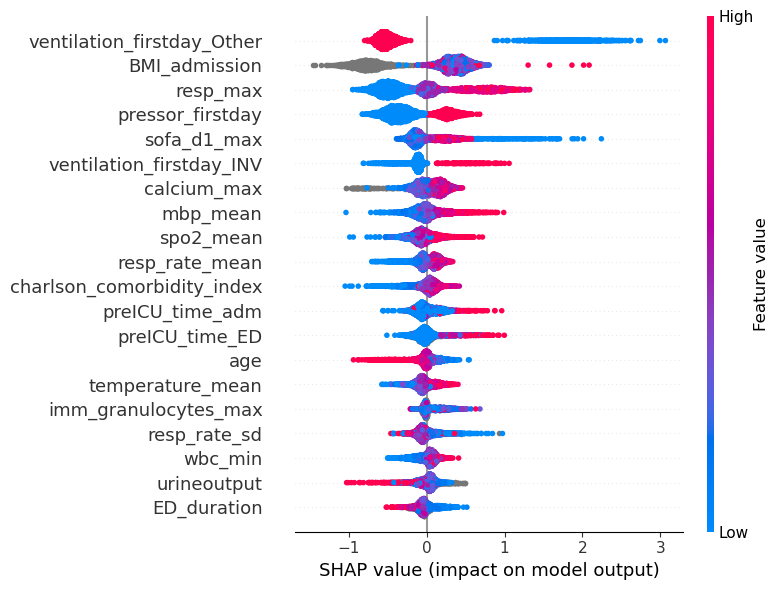

In [25]:
get_explain_plot(fit_model, data.loc[data['set'] == 'val_post_covid', features])

In [ ]:
# next step train with covid and test with covid